# 2. Data cleaning

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as st

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## 2.1. Clean the course data

### 2.1.1 Import the data from the csv file

In [351]:
df_courses=pd.read_csv('data/raw/df_courses.csv', index_col=0)
df_courses.head(1)

,_class,alternate_redirect_course_id,apple_in_app_price_detail,apple_in_app_product_id,apple_in_app_purchase_price_text,archive_time,avg_rating,avg_rating_recent,badges,bestseller_badge_content,...,status_label,subscription_locale,target_audiences,title,type_label,url,visible_instructors,was_ever_published,what_you_will_learn_data,who_should_attend_data
0,course,0,"{'currency': 'USD', 'currency_symbol': '$', 'p...",com.udemy.consumable.11,$10.99,NaN,4.53965,4.53139,"[{'context_info': {'subcategory': None, 'label...","{'badge_family': 'bestseller', 'id': 'd16462d4...",...,Live,NaN,"['Anyone interested in Machine Learning.', 'St...",Machine Learning A-Z™: Hands-On Python & R In ...,course,/machinelearning/,[{'image_50x50': 'https://udemy-images.udemy.c...,True,{'items': ['Master Machine Learning on Python ...,{'items': ['Anyone interested in Machine Learn...


### 2.1.2 Investigate the columns

I investigated the columns which can be useful for clustering the dataset. I removed the non-significant columns and transformed the significant ones.

In [352]:
#check for significant columns 
for col, vol in zip(df_courses.columns, df_courses.iloc[0,:]):
    print(col,':', vol)

_class : course
alternate_redirect_course_id : 0
apple_in_app_price_detail : {'currency': 'USD', 'currency_symbol': '$', 'price_string': '$10.99', 'amount': 10.99}
apple_in_app_product_id : com.udemy.consumable.11
apple_in_app_purchase_price_text : $10.99
archive_time : nan
avg_rating : 4.53965
avg_rating_recent : 4.53139
badges : [{'context_info': {'subcategory': None, 'label': {'id': 5336, 'title': 'Data Science', 'display_name': 'Data Science', 'topic_channel_url': '/topic/data-science/', 'url': '/topic/data-science/', 'tracking_object_type': 'cl'}, 'category': {'url': '/courses/business/', 'id': 268, 'title': 'Business', 'tracking_object_type': 'cat'}}, '_class': 'ds_course_badge', 'id': 'd16462d45dfd4cc1bcec2a1e6724e95c', 'badge_family': 'bestseller', 'badge_text': 'Best Seller'}]
bestseller_badge_content : {'badge_family': 'bestseller', 'id': 'd16462d45dfd4cc1bcec2a1e6724e95c', 'context_info': {'subcategory': None, 'label': {'id': 5336, 'title': 'Data Science', 'display_name': 'D

In [353]:
cols=['avg_rating', 'avg_rating_recent', 'content_info', 'description', 'has_certificate',  'is_paid',
      'id', 'instructional_level', 'is_enrollable_on_mobile', 'is_owned_by_instructor_team', 'is_practice_test_course', 
      'is_published','num_article_assets' , 'num_curriculum_items','num_lectures', 'num_practice_tests', 'num_quizzes',
      'num_subscribers', 'num_reviews', 'objectives', 'price', 'published_time','published_title','rating',
      'rating_distribution', 'relevancy_score', 'status_label']
df=df_courses[cols]
df.head(1)

,avg_rating,avg_rating_recent,content_info,description,has_certificate,is_paid,id,instructional_level,is_enrollable_on_mobile,is_owned_by_instructor_team,...,num_subscribers,num_reviews,objectives,price,published_time,published_title,rating,rating_distribution,relevancy_score,status_label
0,4.53965,4.53139,41 hours,<p>Interested in the field of Machine Learning...,True,True,950390,All Levels,False,False,...,380584,73048,"['Master Machine Learning on Python & R', 'Hav...",€199.99,2016-09-13T21:43:44Z,machinelearning,4.53139,"[{'rating': 1, 'count': 616}, {'rating': 2, 'c...",110.99933,Live


In [354]:
import ast
df['primary_category']=df_courses['primary_category'].apply(lambda x: ast.literal_eval(x).get('title'))
df['primary_subcategory']=df_courses['primary_subcategory'].apply(lambda x: ast.literal_eval(x).get('title'))
df.head(1)

,avg_rating,avg_rating_recent,content_info,description,has_certificate,is_paid,id,instructional_level,is_enrollable_on_mobile,is_owned_by_instructor_team,...,objectives,price,published_time,published_title,rating,rating_distribution,relevancy_score,status_label,primary_category,primary_subcategory
0,4.53965,4.53139,41 hours,<p>Interested in the field of Machine Learning...,True,True,950390,All Levels,False,False,...,"['Master Machine Learning on Python & R', 'Hav...",€199.99,2016-09-13T21:43:44Z,machinelearning,4.53139,"[{'rating': 1, 'count': 616}, {'rating': 2, 'c...",110.99933,Live,Business,Data & Analytics


In [355]:
#16 subcategories - we will try to cluster these subcategories based on the descriptions
df['primary_subcategory'].value_counts()

Finance               1839
Entrepreneurship      1832
Data & Analytics       873
Management             831
Home Business          785
Communications         744
Project Management     531
Sales                  530
Strategy               385
Operations             307
Other                  302
Media                  270
Real Estate            263
Human Resources        255
Industry               142
Business Law           111
Name: primary_subcategory, dtype: int64

In [356]:
def get_float(text):
    r=re.search('\d+\.*\d*', text)
    if r:
        return float(r.group(0))
    else:
        return np.nan
    

In [357]:
df['content_info']=df['content_info'].apply(lambda x: get_float(x))
df['price']=df['price'].apply(lambda x: get_float(x))
df['published_time']=pd.to_datetime(df['published_time'])
df['published_since_month']=(datetime.datetime.now()-df['published_time']).apply(lambda x: int(x.days/30))
df.head(1)  

,avg_rating,avg_rating_recent,content_info,description,has_certificate,is_paid,id,instructional_level,is_enrollable_on_mobile,is_owned_by_instructor_team,...,price,published_time,published_title,rating,rating_distribution,relevancy_score,status_label,primary_category,primary_subcategory,published_since_month
0,4.53965,4.53139,41.0,<p>Interested in the field of Machine Learning...,True,True,950390,All Levels,False,False,...,199.99,2016-09-13 21:43:44,machinelearning,4.53139,"[{'rating': 1, 'count': 616}, {'rating': 2, 'c...",110.99933,Live,Business,Data & Analytics,29


In [358]:
rating_orig=[]
rating_rel=[]
for i, rating in enumerate(df['rating_distribution'].values):
    total=0
    temp={}
    temp_rel={}
    if rating:
        rating=ast.literal_eval(rating)
        for rating_j in rating:
            j=rating_j['rating']
            count_j=rating_j['count']
            total+=count_j
            temp[j]=count_j
        rating_orig.append(temp)
        if total>0:
            for k,v in temp.items():
                temp_rel[k]=round(v*1.0/total,3)
            rating_rel.append(temp_rel)
        else:
            rating_rel.append({1:0, 2:0, 3:0, 4:0, 5:0})
    else:
        rating_rel.append({1:0, 2:0, 3:0, 4:0, 5:0})
        rating_orig.append({1:0, 2:0, 3:0, 4:0, 5:0})
df_rating=pd.DataFrame(rating_rel)
df_rating.columns=['rating_1', 'rating_2', 'rating_3', 'rating_4','rating_5']
print(df_rating.shape)
print(df.shape)

df_rating.head()

(10000, 5)
(10000, 30)


,rating_1,rating_2,rating_3,rating_4,rating_5
0,0.008,0.019,0.100,0.344,0.529
1,0.004,0.009,0.076,0.360,0.551
2,0.007,0.011,0.070,0.340,0.572
3,0.004,0.008,0.057,0.322,0.609
4,0.012,0.024,0.120,0.314,0.531


In [359]:
df=pd.concat([df, df_rating], axis=1)
print(df.shape)

df.head(1)

(10000, 35)


,avg_rating,avg_rating_recent,content_info,description,has_certificate,is_paid,id,instructional_level,is_enrollable_on_mobile,is_owned_by_instructor_team,...,relevancy_score,status_label,primary_category,primary_subcategory,published_since_month,rating_1,rating_2,rating_3,rating_4,rating_5
0,4.53965,4.53139,41.0,<p>Interested in the field of Machine Learning...,True,True,950390,All Levels,False,False,...,110.99933,Live,Business,Data & Analytics,29,0.008,0.019,0.1,0.344,0.529


In [360]:
#Filter courses that are live and public
print('original: ', df.shape)
df=df[(df['is_published']== True ) & (df['status_label']== 'Live')]
print('after filtering live and published courses: ', df.shape)

original:  (10000, 35)
after filtering live and published courses:  (9999, 35)


In [361]:
df.drop(columns=['published_time','rating_distribution','status_label', 'is_published', 'rating' ], axis=1, inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 9999
Data columns (total 30 columns):
avg_rating                     9999 non-null float64
avg_rating_recent              9999 non-null float64
content_info                   9999 non-null float64
description                    9996 non-null object
has_certificate                9999 non-null bool
is_paid                        9999 non-null bool
id                             9999 non-null int64
instructional_level            9990 non-null object
is_enrollable_on_mobile        9999 non-null bool
is_owned_by_instructor_team    9999 non-null bool
is_practice_test_course        9999 non-null bool
num_article_assets             9999 non-null int64
num_curriculum_items           9999 non-null int64
num_lectures                   9999 non-null int64
num_practice_tests             9999 non-null int64
num_quizzes                    9999 non-null int64
num_subscribers                9999 non-null int64
num_reviews            

### 2.1.2 Check for duplicates

In [362]:
#the duplicates in the dataframe
print('The number of duplicates in the dataframe: ', len(df[pd.DataFrame.duplicated(df)]))
df[pd.DataFrame.duplicated(df)].head(2)

The number of duplicates in the dataframe:  1130


,avg_rating,avg_rating_recent,content_info,description,has_certificate,is_paid,id,instructional_level,is_enrollable_on_mobile,is_owned_by_instructor_team,...,published_title,relevancy_score,primary_category,primary_subcategory,published_since_month,rating_1,rating_2,rating_3,rating_4,rating_5
576,4.40000,4.44226,2.5,"<ul><li><p><em>Over</em><strong><em> 105,000 p...",True,True,805704,All Levels,False,False,...,how-to-start-a-business-with-no-money-borrowin...,110.031590,Business,Entrepreneurship,33,0.028,0.037,0.134,0.224,0.576
612,4.35944,4.38518,4.5,<p>This is the only online course you need to ...,True,True,1978132,All Levels,False,False,...,the-project-management-course-beginner-to-proj...,110.029655,Business,Project Management,4,0.000,0.023,0.146,0.401,0.430


In [363]:
df=df.drop_duplicates(subset='id', keep='first')
df.shape

(8869, 30)

### 2.1.3 check the missing values

In [364]:
#There are 4 columns with missing values:
df.columns[df.isnull().any()]

Index(['description', 'instructional_level', 'price'], dtype='object')

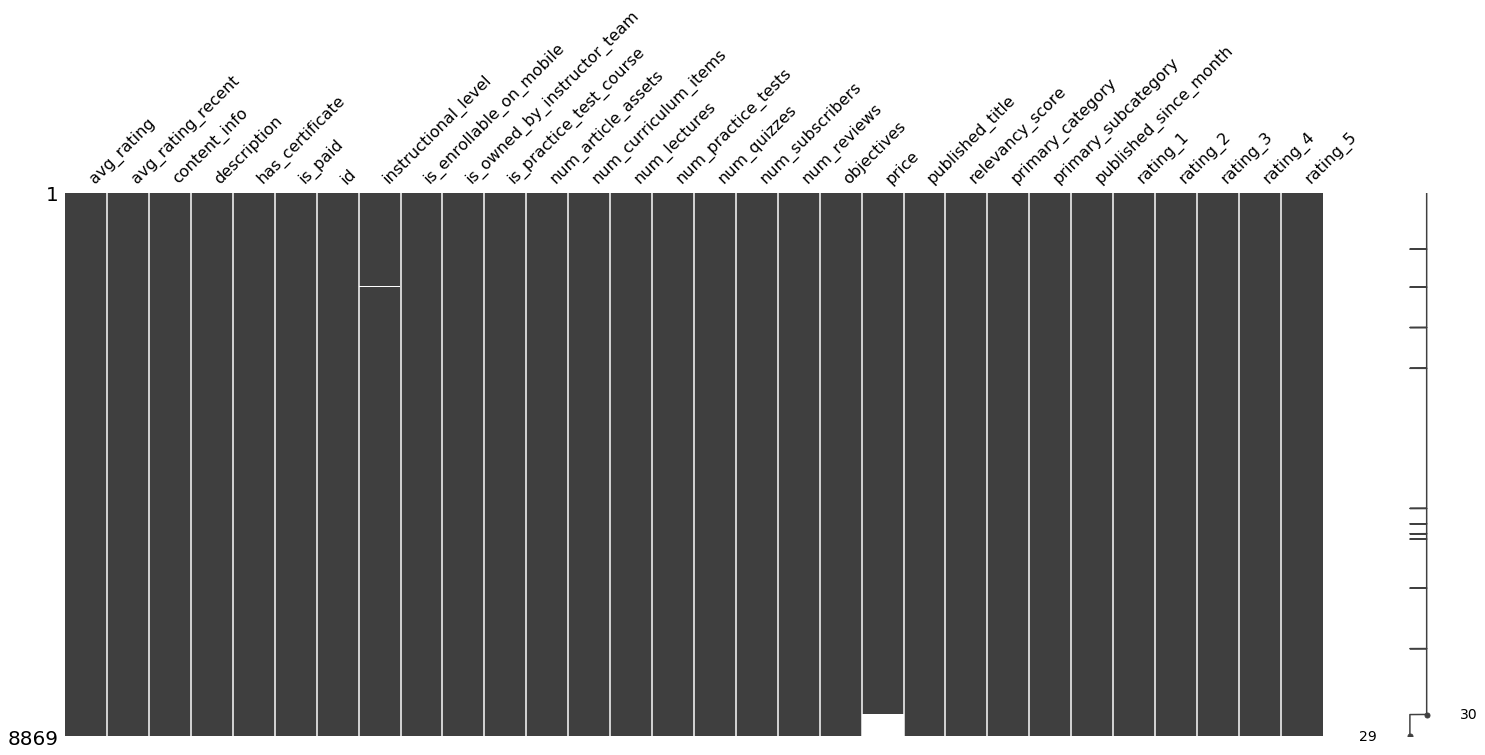

In [365]:
import missingno as msno

msno.matrix(df)

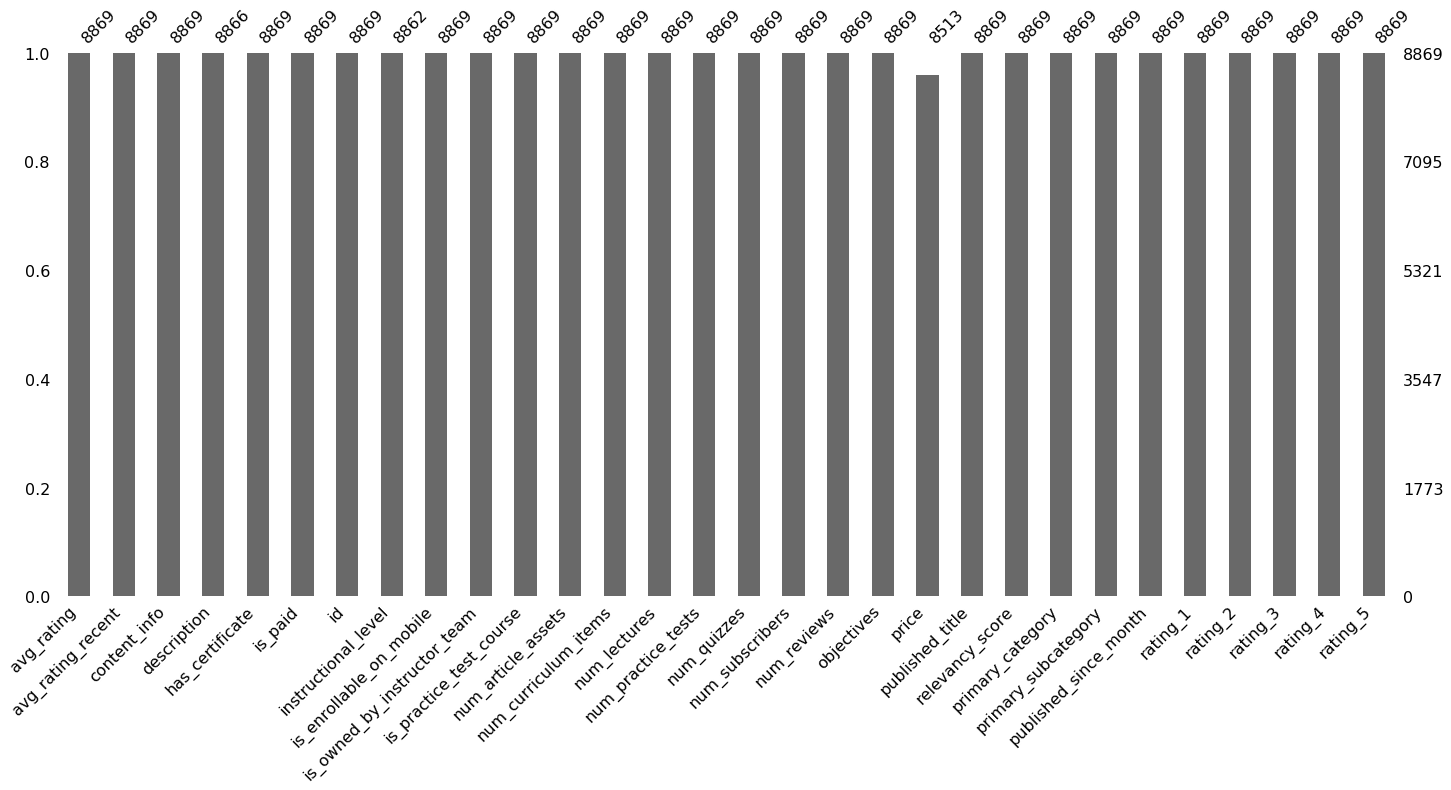

In [366]:
msno.bar(df)

In [367]:
#couple examples with missings:
missing_cols=df.columns[df.isnull().any()]
for c in missing_cols:
    print(c)
    print(df[df[c].isnull()].head()['id'])

description
2897    10971
5663    19958
5852    10964
Name: id, dtype: int64
instructional_level
923     1355782
1547    1422920
2218    1500464
5372    1396300
5958    1428070
Name: id, dtype: int64
price
9644    133536
9645    980086
9646    236676
9647     50132
9648    171838
Name: id, dtype: int64


In [398]:
df_courses[df_courses.id==1355782]['instructional_level']

923    NaN
Name: instructional_level, dtype: object

In [377]:
##The free courses are labeled as free -> change price for these courses: 0 

In [388]:
##All missings are free courses - replace missings by 0
price_list=list(df[df.price.isnull()]['id'].values)

df_courses[df_courses.id.isin(price_list)]['price'].value_counts()

Free    356
Name: price, dtype: int64

In [405]:
import math

#df['price_']=df['price'].apply(lambda x: 0 if x==np.nan else x)
#df['price_']=df['price'].apply(lambda x: 0 if x.isnull() else x)
####fillna(0)!!!!!!
df['price']=df['price'].apply(lambda x: 0 if math.isnan(x) else x)
len(df[df.price.isnull()])

0

In [369]:
#distribution (histogram+boxplot)

#var_num=['avg_rating', 'avg_rating_recent', 'content_info','num_article_assets' , 'num_curriculum_items',
         #'num_lectures', 'num_practice_tests', 'num_quizzes','num_subscribers', 'num_reviews', 
         #'price', 'relevancy_score', 'published_since_month', 'rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5']
    
#barchart
#var_char=['has_certificate', 'is_paid', 'instructional_level', 'is_enrollable_on_mobile','is_owned_by_instructor_team',
            #'is_practice_test_course', 'primary_category', 'primary_subcategory' ]
#var_text=['description','published_title', 'objectives','id']



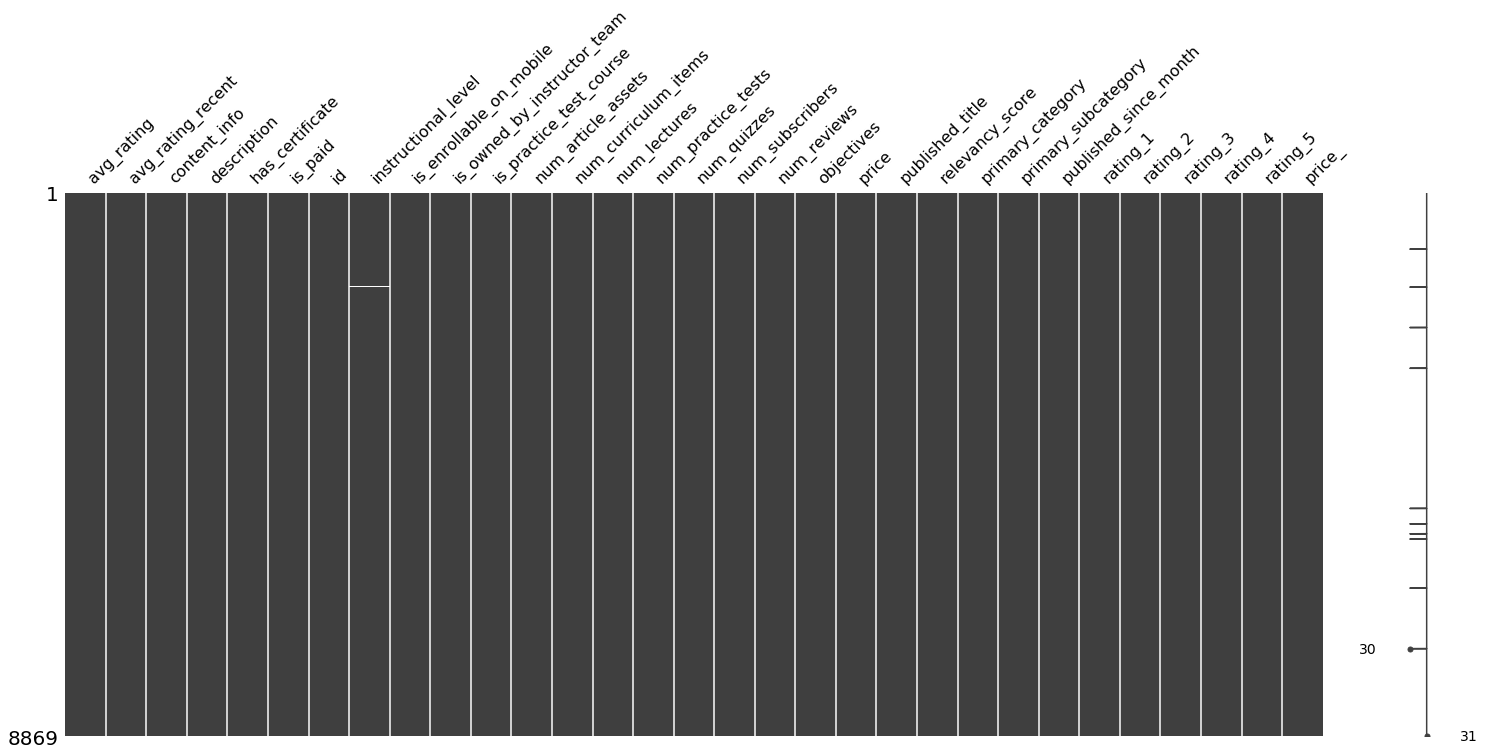

In [406]:
#There are 3 missings by description and 7 missing values by instructional level -> I dropped these rows
msno.matrix(df)

In [407]:
df.dropna(how='any', inplace=True)

In [415]:
df.shape

(8859, 30)

In [423]:
###drop out [] in objectives

index_to_drop=df[df.objectives=="[]"].index
df.drop(index=index_to_drop, inplace=True)
df.shape

(8834, 30)

In [424]:
df.to_csv('data/cleaned/df_courses.csv')

## 2.2. Clean the reviews data

In [2]:
df_review=pd.read_csv('data/raw/df_review.csv', index_col=0)
df_review.head()

,_class,content,course_id,created,id,modified,rating,title,user,user_modified
0,course_review,"Yes, these videos provide sufficient informati...",950390,2019-02-23T23:23:12Z,27811194.0,2019-02-24T03:02:37Z,4.5,NaN,"{'display_name': 'Vikas K', 'title': 'Vikas K'...",2019-02-23T23:24:26Z
1,course_review,The instructors seem to explain concepts well,950390,2019-02-23T22:52:43Z,27810514.0,2019-02-24T03:02:37Z,4.5,NaN,"{'display_name': 'Alicia Kyo', 'title': 'Alici...",2019-02-23T22:53:15Z
2,course_review,NaN,950390,2019-02-23T22:52:13Z,27810496.0,2019-02-24T03:02:37Z,2.5,NaN,"{'display_name': 'Godfred Narkwa', 'title': 'G...",2019-02-23T22:52:55Z
3,course_review,NaN,950390,2019-02-23T22:43:44Z,27810232.0,2019-02-24T03:02:37Z,5.0,NaN,"{'display_name': 'Moustaine Adegbindin', 'titl...",2019-02-23T22:43:46Z
4,course_review,"Going through the sections of this course, the...",950390,2019-02-23T22:27:37Z,27809810.0,2019-02-24T03:02:37Z,5.0,NaN,"{'display_name': 'Krutika Chandrashekhar Pai',...",2019-02-23T22:30:14Z


In [3]:
df_review.shape

(1415734, 10)

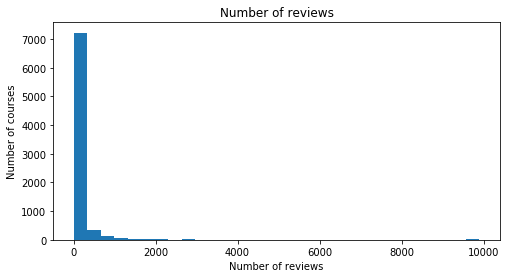

In [5]:
nr_reviews=df_review['course_id'].value_counts()
#number of ratings
ax, fig= plt.subplots(figsize=(8,4))
plt.hist(nr_reviews, bins=30)
plt.xlabel('Number of reviews')
plt.ylabel('Number of courses')
plt.title('Number of reviews')
plt.show()
#most courses have very few reviews

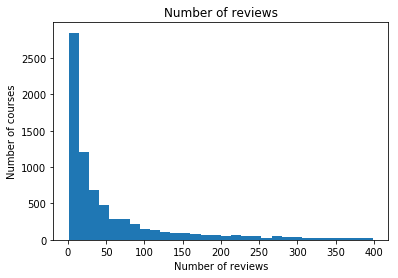

In [505]:
#shows only courses with less than 400 reviews
plt.hist(nr_reviews[nr_reviews<400], bins=30)
plt.xlabel('Number of reviews')
plt.ylabel('Number of courses')
plt.title('Number of reviews')
plt.show()

In [6]:
#get user name
import ast
df_review['user_name']=df_review['user'].apply(lambda x: ast.literal_eval(x).get('display_name'))
df_review['user_title']=df_review['user'].apply(lambda x: ast.literal_eval(x).get('title'))

df_review.head(1)

,_class,content,course_id,created,id,modified,rating,title,user,user_modified,user_name,user_title
0,course_review,"Yes, these videos provide sufficient informati...",950390,2019-02-23T23:23:12Z,27811194.0,2019-02-24T03:02:37Z,4.5,NaN,"{'display_name': 'Vikas K', 'title': 'Vikas K'...",2019-02-23T23:24:26Z,Vikas K,Vikas K


In [453]:
#unfortunately we dont have user id-s.
#check the difference between user_name and user_title
df_review[df_review['user_name']!=df_review['user_title']]

,_class,content,course_id,created,id,modified,rating,title,user,user_modified,user_name,user_title
87,course_review,NaN,950390,2019-02-22T20:09:04Z,27769834.0,2019-02-23T03:05:29Z,5.0,NaN,"{'display_name': 'Udemy User', 'title': '', '_...",2019-02-22T20:09:04Z,Udemy User,
1027,course_review,NaN,950390,2019-02-14T10:04:54Z,27380372.0,2019-02-14T14:02:22Z,4.0,NaN,{'display_name': 'Private Udemy For Business U...,2019-02-14T10:04:56Z,Private Udemy For Business User,
3677,course_review,NaN,950390,2019-01-24T02:03:47Z,26359912.0,2019-01-25T04:03:52Z,4.5,NaN,{'display_name': 'Private Udemy For Business U...,2019-01-24T02:03:47Z,Private Udemy For Business User,
3923,course_review,NaN,950390,2019-01-22T12:48:12Z,26270252.0,2019-01-23T03:03:27Z,5.0,NaN,{'display_name': 'Private Udemy For Business U...,2019-01-22T12:48:26Z,Private Udemy For Business User,
4175,course_review,NaN,950390,2019-01-20T21:26:07Z,26186978.0,2019-01-21T03:02:30Z,5.0,NaN,{'display_name': 'Private Udemy For Business U...,2019-01-20T21:26:09Z,Private Udemy For Business User,
9074,course_review,NaN,950390,2018-12-15T02:01:45Z,24490756.0,2018-12-15T16:09:26Z,3.5,NaN,{'display_name': 'Private Udemy For Business U...,2018-12-15T02:01:46Z,Private Udemy For Business User,
9149,course_review,NaN,950390,2018-12-14T08:50:50Z,24462528.0,2018-12-14T17:06:46Z,5.0,NaN,{'display_name': 'Private Udemy For Business U...,2018-12-14T08:50:52Z,Private Udemy For Business User,
9486,course_review,NaN,950390,2018-12-11T14:23:51Z,24341788.0,2018-12-12T03:02:58Z,4.0,NaN,{'display_name': 'Private Udemy For Business U...,2018-12-11T14:23:53Z,Private Udemy For Business User,
9647,course_review,NaN,950390,2018-12-10T09:08:22Z,24284848.0,2018-12-10T15:02:26Z,3.0,NaN,{'display_name': 'Private Udemy For Business U...,2018-12-10T09:08:23Z,Private Udemy For Business User,
686,course_review,NaN,903744,2019-02-14T21:53:43Z,27408744.0,2019-02-15T03:02:21Z,3.5,NaN,{'display_name': 'Private Udemy For Business U...,2019-02-14T21:53:44Z,Private Udemy For Business User,


In [455]:
#there are some usernames - first 3 - which I will delete because it definitely belongs to more people
#the other user_names are not unique as well
df_review['user_name'].value_counts()[:5]

Anonymized User                    13160
Private Udemy For Business User     1916
Udemy User                           453
David                                428
Michael                              330
Name: user_name, dtype: int64

In [7]:
df_review=df_review[~df_review['user_name'].isin(['Anonymized User', 'Private Udemy For Business User', 'Udemy User'])]
df_review.head()

,_class,content,course_id,created,id,modified,rating,title,user,user_modified,user_name,user_title
0,course_review,"Yes, these videos provide sufficient informati...",950390,2019-02-23T23:23:12Z,27811194.0,2019-02-24T03:02:37Z,4.5,NaN,"{'display_name': 'Vikas K', 'title': 'Vikas K'...",2019-02-23T23:24:26Z,Vikas K,Vikas K
1,course_review,The instructors seem to explain concepts well,950390,2019-02-23T22:52:43Z,27810514.0,2019-02-24T03:02:37Z,4.5,NaN,"{'display_name': 'Alicia Kyo', 'title': 'Alici...",2019-02-23T22:53:15Z,Alicia Kyo,Alicia Kyo
2,course_review,NaN,950390,2019-02-23T22:52:13Z,27810496.0,2019-02-24T03:02:37Z,2.5,NaN,"{'display_name': 'Godfred Narkwa', 'title': 'G...",2019-02-23T22:52:55Z,Godfred Narkwa,Godfred Narkwa
3,course_review,NaN,950390,2019-02-23T22:43:44Z,27810232.0,2019-02-24T03:02:37Z,5.0,NaN,"{'display_name': 'Moustaine Adegbindin', 'titl...",2019-02-23T22:43:46Z,Moustaine Adegbindin,Moustaine Adegbindin
4,course_review,"Going through the sections of this course, the...",950390,2019-02-23T22:27:37Z,27809810.0,2019-02-24T03:02:37Z,5.0,NaN,"{'display_name': 'Krutika Chandrashekhar Pai',...",2019-02-23T22:30:14Z,Krutika Chandrashekhar Pai,Krutika Chandrashekhar Pai


In [506]:
#keep only the relevant columns: user_name, course_id, rating
nr_user[:10]

David                         428
Michael                       330
John                          326
Chris                         319
James                         300
Redvers Crooks                274
Alex                          260
Daniel                        252
Ahmed Ismail Ahmed Mohamed    245
Mike                          237
Name: user_name, dtype: int64

In [469]:
#check for reviews per user_name (but user _name is not unique..)
nr_user=df_review['user_name'].value_counts()
unique, counts = np.unique(nr_user, return_counts=True)
dict(zip(unique, counts))

{1: 623905,
 2: 126640,
 3: 44913,
 4: 21706,
 5: 11704,
 6: 6771,
 7: 4099,
 8: 2639,
 9: 1837,
 10: 1382,
 11: 997,
 12: 728,
 13: 616,
 14: 422,
 15: 349,
 16: 288,
 17: 250,
 18: 201,
 19: 144,
 20: 164,
 21: 134,
 22: 109,
 23: 104,
 24: 89,
 25: 80,
 26: 82,
 27: 72,
 28: 70,
 29: 51,
 30: 36,
 31: 35,
 32: 31,
 33: 32,
 34: 33,
 35: 31,
 36: 21,
 37: 29,
 38: 32,
 39: 23,
 40: 23,
 41: 14,
 42: 12,
 43: 13,
 44: 20,
 45: 13,
 46: 16,
 47: 15,
 48: 9,
 49: 10,
 50: 12,
 51: 8,
 52: 10,
 53: 13,
 54: 4,
 55: 12,
 56: 10,
 57: 5,
 58: 12,
 59: 8,
 60: 7,
 61: 3,
 62: 5,
 63: 8,
 64: 9,
 65: 7,
 66: 7,
 67: 3,
 68: 5,
 69: 5,
 70: 5,
 71: 2,
 72: 6,
 73: 5,
 74: 1,
 75: 4,
 76: 2,
 77: 4,
 78: 3,
 79: 3,
 80: 2,
 81: 5,
 82: 2,
 83: 7,
 84: 5,
 85: 1,
 86: 2,
 87: 3,
 88: 3,
 89: 1,
 90: 4,
 91: 2,
 92: 1,
 93: 1,
 94: 4,
 96: 4,
 97: 2,
 98: 1,
 99: 2,
 100: 1,
 101: 2,
 102: 2,
 103: 1,
 105: 2,
 106: 2,
 107: 1,
 108: 1,
 109: 1,
 110: 3,
 111: 1,
 113: 2,
 114: 2,
 116: 1,
 117:

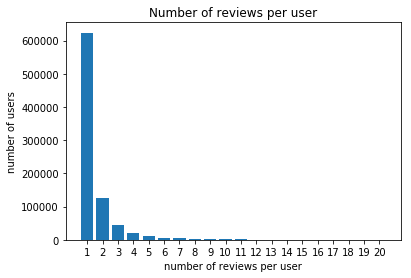

In [511]:
#plot the first 20 value#most users (more than 600000) have only 1 review
plt.bar(np.arange(len(counts[:20])), counts[:20], align='center')
plt.xticks(np.arange(len(counts[:20])), unique[:20])
plt.xlabel('number of reviews per user')
plt.ylabel('number of users')
plt.title('Number of reviews per user')
plt.show()

In [488]:
names=nr_user[nr_user==5][:5].index
for n in names:
    courses=df_review[df_review['user_name']==n]['course_id'].values
    print(n)
    for c in courses:
        c_name=df_courses[df_courses.id==c]['title'].values[0]
        print(c_name)
    print()

Adeboye Akinwunmi
SQL for Newbs: Data Analysis for Beginners
Powerful Reports and Dashboards with Microsoft Power BI
Become QlikView Developer from Scratch
Tableau 10 Desktop Training
Applied Analytics (business application - non mathematical)

Arthol L
Tableau 10 A-Z: Hands-On Tableau Training For Data Science!
R Programming A-Z™: R For Data Science With Real Exercises!
The Ultimate Hands-On Hadoop - Tame your Big Data!
Apache Spark 2 with Scala - Hands On with Big Data!
Tableau 10 Advanced Training: Master Tableau in Data Science

David I Kimura
Become a Product Manager | Learn the Skills & Get the Job
Beginner to Pro in Excel: Financial Modeling and Valuation
The Complete Shopify Aliexpress Dropship course
Fundamentals of Analyzing Real Estate Investments
Introduction to Financial Modeling

Mathieu Lemaire
Cryptocurrency Investment Course 2019: Fund your Retirement!
#1 Cryptocurrency Long-term Investment Opportunity 2017/2018
Editing Mastery: How To Edit Writing To Perfection
Punctu

In [8]:
#keep the relevant columns
#since the users are not unique, it is not possible to build a recommender system based on the user data
cols=['course_id', 'created', 'rating', 'user_name']
df_review_rel=df_review[cols]

In [9]:
df_review_rel.shape

(1400205, 4)

In [503]:
#export the user data
df_review_rel.to_csv('data/cleaned/df_reviews.csv')